<a href="https://colab.research.google.com/github/theaok/vis-sp23-ewattudo/blob/main/ps3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PS3 One More Merge and Visualization - Erick Watt-Udogu

I am generally interested in creating a model that will help explain who applied to Rutgers-Camden's Graduate School of Arts and Sciences for the following terms: summer 2022, fall 2022 and spring 2023.

This project is broken into two sections. First, I am interested in creating an OLS model that will identify the correlates with number of applications and those people who accept. In the last project, I was unable to determine the relationship between unemployment rates and applications because so many applicants resided in Camden county. To address this, I am using the merging portion of the project to add more external variables to my dataset with the goal of avoiding left out variable bias. In this project I added education attainment and houshold income data. However, I did not use this for the storytelling portion.

For the storytellng portion of the project, I focused on an anlysis of the initial dataset, in particular I wanted to learn more about when  when an applicant applies because my hypothesis was that getting people to apply early had positive results. But I found almost everything about the days between the creation of the application and the beginning of the semester quite surprising.

## Setup Code

In [65]:
#---------------------------SETUP----------------------------------
#get useful libraries
import time, os, sys, re #basics
import zipfile, json, datetime, string   #string for annotating points in scatter
import numpy as np #basic math
from statistics import * #stats

import matplotlib.pyplot as plt #import pylab as plt #apparently discouraged now:
 #https://stackoverflow.com/questions/11469336/what-is-the-difference-between-pylab-and-pyplot
 #https://www.tutorialspoint.com/matplotlib/matplotlib_pylab_module.htm
from matplotlib.ticker import StrMethodFormatter

import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import wb
from pandas.io.formats.style import Styler
#s4 = Styler(df4, uuid_len=0, cell_ids=False)

import urllib  #weird, guess need to have os and pandas imported for this to work  %TODO/LATER ditch it, its weird anyway, just use wget/curl

from google.colab import files

#import webbrowser

import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )

#many tricks how to extend notebook functionality
#https://coderzcolumn.com/tutorials/python/list-of-useful-magic-commands-in-jupyter-notebook-lab
#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#MAGICS and THEMES/STYLES: important! does affect not just shading/colors, but also fonts, spacing, etc
#(even if you only select default (v not selecting anything) [but does seem to work better if you do make explicit sleections])

###magics: https://ipython.readthedocs.io/en/stable/interactive/magics.html
#most essential setup for vis: it does affect vis! careful!! stick with inline, maybe notebook; others mostly for non-notebook, eg spyder environ
#https://jakevdp.github.io/PythonDataScienceHandbook/04.00-introduction-to-matplotlib.html recomends *inline*!
#show current one:
#%matplotlib
#%matplotlib --list
#interactive plots:
#%matplotlib notebook
#static images of your plot:
%matplotlib inline
#may play with this one and other magics (btw default is probably agg)
#%matplotlib nbagg

###themes/styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
#https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html
#https://matplotlib.org/stable/tutorials/introductory/customizing.html
#here more about art and style than under the hood functionality as with magics, explore and experiment
#many may find 'default' or seaborn ones more pleasing; my fav 'classic' is back from 90s ;)
#plt.style.available #list available styles :) may install more
#plt.style.use('default') # more delicate subtle than classic
#plt.style.use('seaborn-poster')  #  'seaborn-whitegrid' 'seaborn-white' 'seaborn-poster'
# btw: magics v theme/style sequence matters, eg if i specify classic style before inline magic, i wouldnt get grey bounding box im getting

## Importing and Cleaning Files

aok can simplify, eg import and cleaning together, no need for a separate section for import

in general try to simplify and cut stuff, you have a lot of code, see if can have fewer lines and simpler

throught when merging probably want to keep all applicants data whether it matches or not with other data; otherwhise some applicants get dropped and will be getting different results from merged v original data, and thats probably not what you want

overall: nice; but think more about merge, eg keep all appdata eg merge type left or right; try to do main vis after merge

### Import 1 - Application Data
This is data I retrieved from work. I cleaned identifying information.

In [66]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ewattudo/vis1/main/appdata.csv", "appdata")

('appdata', <http.client.HTTPMessage at 0x7ef11d1d05d0>)

In [67]:
os.getcwd() #pwd
os.listdir() #compare to clicking on the left the folder icon #dir

'/content'

['.config',
 'appdata',
 'njhighested.csv',
 'njunemp21.csv',
 'njhhinc.csv',
 'sample_data']

In [68]:
appdat=pd.read_csv('appdata')

### Cleaning the Data 1 - Application Data

In [69]:
appdat.columns

Index(['ID ', 'Degree Type', 'Final Recommended Decision', 'Admit-Coming',
       'Application Created Date', 'Days Before the Beginning of Semester ',
       'Domestic or INTL Applicant', 'Reporting Term', 'Age When Applied',
       'Mailing Zip/Postal Code', 'Mailing State/Province', 'Mailing Country',
       'Most Recent Educational Institution: Account Name', 'Gender', 'Race',
       'Program Selection: Program Selection Name', 'Admissions Status'],
      dtype='object')

In [70]:
appdat.head(3)

,ID,Degree Type,Final Recommended Decision,Admit-Coming,Application Created Date,Days Before the Beginning of Semester,Domestic or INTL Applicant,Reporting Term,Age When Applied,Mailing Zip/Postal Code,Mailing State/Province,Mailing Country,Most Recent Educational Institution: Account Name,Gender,Race,Program Selection: Program Selection Name,Admissions Status
0,1,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,12/7/2021,273,International,Fall 2022,23.0,56407,Pradesh 2,Nepal,Vellore Institute Of Technolog,Male,Asian,Biology: Computational and Integrative (MS),Started App
1,2,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,1/2/2022,247,International,Fall 2022,21.0,380058,Gujarat,India,Ahmedabad University,Female,Asian,Biology: Computational and Integrative (MS),Started App
2,3,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,3/15/2022,175,Domestic,Fall 2022,22.0,07009-1245,New Jersey,United States,Mount Olive High School,Male,Asian,Biology: Computational and Integrative (MS),Started App


In [71]:
appdat.dtypes

,0
ID,int64
Degree Type,object
Final Recommended Decision,object
Admit-Coming,int64
Application Created Date,object
Days Before the Beginning of Semester,int64
Domestic or INTL Applicant,object
Reporting Term,object
Age When Applied,float64
Mailing Zip/Postal Code,object


In [72]:
appdat = appdat.rename(columns={"Admit-Coming":"AdmitComing","Days Before the Beginning of Semester ":"Days","Age When Applied":"Age","Domestic or Intl":"Domestic", 'Mailing Zip/Postal Code':"Zip", "Mailing State/Province":"State","Mailing Country":"Country", "Program Selection: Program Selection Name":"Program"  })
appdat.head(3)

,ID,Degree Type,Final Recommended Decision,AdmitComing,Application Created Date,Days,Domestic or INTL Applicant,Reporting Term,Age,Zip,State,Country,Most Recent Educational Institution: Account Name,Gender,Race,Program,Admissions Status
0,1,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,12/7/2021,273,International,Fall 2022,23.0,56407,Pradesh 2,Nepal,Vellore Institute Of Technolog,Male,Asian,Biology: Computational and Integrative (MS),Started App
1,2,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,1/2/2022,247,International,Fall 2022,21.0,380058,Gujarat,India,Ahmedabad University,Female,Asian,Biology: Computational and Integrative (MS),Started App
2,3,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,3/15/2022,175,Domestic,Fall 2022,22.0,07009-1245,New Jersey,United States,Mount Olive High School,Male,Asian,Biology: Computational and Integrative (MS),Started App


In [73]:
appdat.columns

Index(['ID ', 'Degree Type', 'Final Recommended Decision', 'AdmitComing',
       'Application Created Date', 'Days', 'Domestic or INTL Applicant',
       'Reporting Term', 'Age', 'Zip', 'State', 'Country',
       'Most Recent Educational Institution: Account Name', 'Gender', 'Race',
       'Program', 'Admissions Status'],
      dtype='object')

In [74]:
usappdat = appdat.query("Country=='United States'")
usappdat.head(3)

,ID,Degree Type,Final Recommended Decision,AdmitComing,Application Created Date,Days,Domestic or INTL Applicant,Reporting Term,Age,Zip,State,Country,Most Recent Educational Institution: Account Name,Gender,Race,Program,Admissions Status
2,3,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,3/15/2022,175,Domestic,Fall 2022,22.0,07009-1245,New Jersey,United States,Mount Olive High School,Male,Asian,Biology: Computational and Integrative (MS),Started App
3,4,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,3/31/2022,159,Domestic,Fall 2022,23.0,07726-4660,New Jersey,United States,Suny Colg Geneseo,Female,Hispanic or Latino; White,Biology: Computational and Integrative (MS),Started App
5,6,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,4/20/2022,272,Domestic,Spring 2023,33.0,08755-1914,New Jersey,United States,Essex County College,Male,Black or African American,Biology: Computational and Integrative (MS),Started App


In [75]:
njappdat = usappdat.query("State=='New Jersey'")
njappdat.head(3)


,ID,Degree Type,Final Recommended Decision,AdmitComing,Application Created Date,Days,Domestic or INTL Applicant,Reporting Term,Age,Zip,State,Country,Most Recent Educational Institution: Account Name,Gender,Race,Program,Admissions Status
2,3,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,3/15/2022,175,Domestic,Fall 2022,22.0,07009-1245,New Jersey,United States,Mount Olive High School,Male,Asian,Biology: Computational and Integrative (MS),Started App
3,4,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,3/31/2022,159,Domestic,Fall 2022,23.0,07726-4660,New Jersey,United States,Suny Colg Geneseo,Female,Hispanic or Latino; White,Biology: Computational and Integrative (MS),Started App
5,6,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,4/20/2022,272,Domestic,Spring 2023,33.0,08755-1914,New Jersey,United States,Essex County College,Male,Black or African American,Biology: Computational and Integrative (MS),Started App


In [76]:
njappdat['C_Zip']=njappdat['Zip'].str[:5]
njappdat.head(3)

<ipython-input-76-088877dd01eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  njappdat['C_Zip']=njappdat['Zip'].str[:5]


,ID,Degree Type,Final Recommended Decision,AdmitComing,Application Created Date,Days,Domestic or INTL Applicant,Reporting Term,Age,Zip,State,Country,Most Recent Educational Institution: Account Name,Gender,Race,Program,Admissions Status,C_Zip
2,3,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,3/15/2022,175,Domestic,Fall 2022,22.0,07009-1245,New Jersey,United States,Mount Olive High School,Male,Asian,Biology: Computational and Integrative (MS),Started App,07009
3,4,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,3/31/2022,159,Domestic,Fall 2022,23.0,07726-4660,New Jersey,United States,Suny Colg Geneseo,Female,Hispanic or Latino; White,Biology: Computational and Integrative (MS),Started App,07726
5,6,"Master's (e.g. MA, MS, EdM, MFA)",NaN,0,4/20/2022,272,Domestic,Spring 2023,33.0,08755-1914,New Jersey,United States,Essex County College,Male,Black or African American,Biology: Computational and Integrative (MS),Started App,08755


In [77]:
#cleaned the zip codes with missing leading zeroes. This was painfully inefficient. I need to come learn if statement syntax.
njappdat=njappdat.replace({'C_Zip':{'8904':'08904',	'7306':'07306',	'8102':'08102',
                                        '7036':'07036',	'8401':'08401',	'8064':'08064',
                                        '8002':'08002',	'8060':'08060',	'8043':'08043',
                                        '8810':'08810',	'8033':'08033',	'8817':'08817',
                                        '7960':'07960',	'8054':'08054',	'8505':'08505',
                                        '7111':'07111',	'8104':'08104',	'7734':'07734',
                                        '8078':'08078',	'8081':'08081',	'8059':'08059',
                                        '8830':'08830',	'7055':'07055',	'8075':'08075',
                                        '8824':'08824',	'8869':'08869',	'8857':'08857',
                                        '8012':'08012',	'8015':'08015',	'8077':'08077',
                                        '7724':'07724',	'7203':'07203',	'8030':'08030',
                                        '8108':'08108',	'7003':'07003',	'8093':'08093',
                                        '8071':'08071',	'8088':'08088',	'7110':'07110',
                                        '8055':'08055',	'8873':'08873',	'8046':'08046',
                                        '8068':'08068',	'8107':'08107',	'7076':'07076',
                                        '8009':'08009',	'7079':'07079',	'8533':'08533',
                                        '8052':'08052',	'8053':'08053',	'8755':'08755',
                                        '8217':'08217',	'7302':'07302',	'7104':'07104',
                                        '8021':'08021',	'8034':'08034',	'7050':'07050',
                                        '8094':'08094',	'8753':'08753',	'8618':'08618',
                                        '7701':'07701',	'8090':'08090',	'8110':'08110',
                                        '8322':'08322',	'8232':'08232'}})

In [78]:
#identify partial string to look for
discard = ["X"]
#drop rows that contain the partial string "X" in the C_Zip column
njappdat = njappdat[~njappdat.C_Zip.str.contains('|'.join(discard))]

In [79]:
#Leading Zeroes added and XXs removed.
print(njappdat.C_Zip.unique())

['07009' '07726' '08755' '08850' '07052' '07871' '08034' '08107' '07522'
 '08016' '08012' '07306' '07450' '08055' '08004' '08102' '08002' '08083'
 '07036' '08003' '08824' '08066' '08031' '08536' '08109' '08028' '08527'
 '08108' '08558' '08904' '08873' '08401' '07304' '08052' '08103' '08502'
 '08088' '08064' '08837' '08048' '08007' '08005' '08021' '08060' '08081'
 '08046' '08075' '08053' '08104' '08043' '08360' '08901' '08330' '08810'
 '08520' '08817' '08204' '07666' '08865' '08078' '08618' '07031' '08234'
 '07030' '08057' '08505' '07045' '08690' '07111' '08022' '07830' '08753'
 '07735' '08343' '07311' '08105' '08009' '07103' '08093' '08611' '07753'
 '07675' '08065' '07108' '08059' '08096' '08830' '08833' '07728' '08010'
 '08869' '08071' '08857' '08361' '08205' '08619' '08037' '08049' '08015'
 '07724' '07436' '07083' '07060' '08822' '07055' '08861' '07011' '08061'
 '07747' '07109' '08512' '08317' '08610' '08876' '07405' '08087' '08648'
 '07960' '07063' '07719' '08816' '08844' '07047' '0

### Import 2 - New Jersey Unemployment Data
Retrieved this data from Social Explorer https://www.socialexplorer.com/tables/US_unemployment_2021/R13293445.

In [80]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ewattudo/vis1/main/R13290836_SL050.csv", "njunemp21.csv")

('njunemp21.csv', <http.client.HTTPMessage at 0x7ef11b82fbd0>)

In [81]:
os.getcwd() #pwd
os.listdir() #compare to clicking on the left the folder icon #dir

'/content'

['.config',
 'appdata',
 'njhighested.csv',
 'njunemp21.csv',
 'njhhinc.csv',
 'sample_data']

In [82]:
njunemp=pd.read_csv('njunemp21.csv')

### Cleaning the Data 2 - New Jersey Unemployment Data

In [83]:
#Rename is extremely important here, because the column headers are not intuitive.I am glad I had the url listed.
njunemp.columns


Index(['Geo_FIPS', 'Geo_NAME', 'Geo_QNAME', 'Geo_NATION', 'Geo_STATE',
       'Geo_COUNTY', 'Geo_MSA', 'ORG_US_007_001', 'ORG_US_007_002',
       'ORG_US_007_003', 'ORG_US_007_004', 'ORG_US_Unemployment_027_001',
       'ORG_US_Unemployment_027_002', 'ORG_US_Unemployment_027_003',
       'ORG_US_Unemployment_027_004', 'ORG_US_Unemployment_020_001',
       'ORG_US_Unemployment_020_002', 'ORG_US_Unemployment_020_003',
       'ORG_US_Unemployment_020_004', 'ORG_US_035_001', 'ORG_US_035_002',
       'ORG_US_035_003', 'ORG_US_035_004'],
      dtype='object')

In [84]:
njunemp.dtypes

,0
Geo_FIPS,int64
Geo_NAME,object
Geo_QNAME,object
Geo_NATION,int64
Geo_STATE,int64
Geo_COUNTY,int64
Geo_MSA,float64
ORG_US_007_001,int64
ORG_US_007_002,int64
ORG_US_007_003,int64


In [85]:
njunemp = njunemp.drop(['Geo_FIPS','Geo_QNAME','Geo_NATION','Geo_COUNTY','Geo_MSA'],axis=1)

In [86]:
njunemp = njunemp.rename(columns={'Geo_NAME':"County",
                                  "ORG_US_007_004":"Unemployment2021",
                                  "ORG_US_Unemployment_027_004":"Unemployment2020",
                                  "ORG_US_035_004":"PercentageChange"})

In [87]:
njunemp.dtypes

,0
County,object
Geo_STATE,int64
ORG_US_007_001,int64
ORG_US_007_002,int64
ORG_US_007_003,int64
Unemployment2021,float64
ORG_US_Unemployment_027_001,int64
ORG_US_Unemployment_027_002,int64
ORG_US_Unemployment_027_003,int64
Unemployment2020,float64


In [88]:
njunemp.agg({'Unemployment2020':['mean','median',stdev], 'Unemployment2021':['mean','median',stdev],'PercentageChange':['mean','median',stdev] })

,Unemployment2020,Unemployment2021,PercentageChange
mean,13.857143,7.595238,-44.823672
median,13.200000,7.100000,-45.384615
stdev,3.000262,1.425299,4.966793


In [89]:
njunemp = njunemp.rename(columns={'ORG_US_007_001':"LaborForce2021", "ORG_US_Unemployment_027_001":"LaborForce2020"})

In [90]:
njunemp['County'] = njunemp['County'].str.replace(' County',' ')

### Import 3 - New Jersey Zip Codes
Found the data on a background check website - https://www.corragroup.com/new-jersey-county-lookup.htm

In [91]:
#Found this import code at https://towardsdatascience.com/2-easy-ways-to-get-tables-from-a-website-with-pandas-b92fc835e741. I'll save for later.
pd.read_html('https://www.corragroup.com/new-jersey-county-lookup.html')

[                   City ZIP Code      County
 0                   A C    08401    ATLANTIC
 1              ABERDEEN    07747    MONMOUTH
 2               ABSECON    08201    ATLANTIC
 3       ABSECON HEIGHTS    08201    ATLANTIC
 4     ABSECON HIGHLANDS    08201    ATLANTIC
 ...                 ...      ...         ...
 1250        WRIGHTSTOWN    08562  BURLINGTON
 1251            WYCKOFF    07481      BERGEN
 1252          YARDVILLE    08620      MERCER
 1253           ZAREPATH    08873    SOMERSET
 1254          ZAREPHATH    08890    SOMERSET
 
 [1255 rows x 3 columns]]

In [92]:
pd.read_html('https://www.corragroup.com/new-jersey-county-lookup.html')[0]

,City,ZIP Code,County
0,A C,08401,ATLANTIC
1,ABERDEEN,07747,MONMOUTH
2,ABSECON,08201,ATLANTIC
3,ABSECON HEIGHTS,08201,ATLANTIC
4,ABSECON HIGHLANDS,08201,ATLANTIC
...,...,...,...
1250,WRIGHTSTOWN,08562,BURLINGTON
1251,WYCKOFF,07481,BERGEN
1252,YARDVILLE,08620,MERCER
1253,ZAREPATH,08873,SOMERSET


In [93]:
njzips=pd.read_html('https://www.corragroup.com/new-jersey-county-lookup.html')[0]

### Cleaning the Data 3 - New Jersey Zip Codes

In [94]:
njzips = njzips.rename(columns={'ZIP Code':"C_Zip"})
njzips.head(3)

,City,C_Zip,County
0,A C,08401,ATLANTIC
1,ABERDEEN,07747,MONMOUTH
2,ABSECON,08201,ATLANTIC


In [95]:
#identify partial string to look for
discard = ["X"]
#drop rows that contain the partial string "X" in the C_Zip column
njzips = njzips[~njzips.C_Zip.str.contains('|'.join(discard))]

### Import 4 - New Jersey Highest Educational Attainment For Population 25 Years and Over
Retrieved this data from Social Explorer https://www.socialexplorer.com/tables/ACS2019S/R13306533


In [96]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ewattudo/vis1/main/R13306531_SL050.csv", "njhighested.csv")

('njhighested.csv', <http.client.HTTPMessage at 0x7ef11b8a3c50>)

In [97]:
os.getcwd() #pwd
os.listdir() #compare to clicking on the left the folder icon #dir

'/content'

['.config',
 'appdata',
 'njhighested.csv',
 'njunemp21.csv',
 'njhhinc.csv',
 'sample_data']

In [98]:
njhigh=pd.read_csv('njhighested.csv')

### Cleaning The Data 4 - New Jersey Highest Educational Attainment for Population 25 Years and Over

In [99]:
njhigh.columns

Index(['Geo_FIPS', 'Geo_NAME', 'Geo_QNAME', 'Geo_NATION', 'Geo_REGION',
       'Geo_DIVISION', 'Geo_STATE', 'Geo_COUNTY', 'Geo_CS', 'Geo_PLACE',
       'Geo_CD', 'Geo_SDE', 'Geo_SDS', 'Geo_SDU', 'Geo_PUMA', 'Geo_ANRC',
       'Geo_AIAANAHHL', 'Geo_CSA', 'Geo_MSAMSA', 'Geo_PCOP', 'Geo_MD',
       'Geo_CNECATA', 'Geo_NECATA', 'Geo_PC', 'Geo_ND', 'Geo_UA',
       'SE_T013A001', 'SE_T013A002', 'SE_T013A003', 'SE_T013A004',
       'SE_T013A005', 'SE_T013A006'],
      dtype='object')

In [100]:
njhigh.dtypes

,0
Geo_FIPS,int64
Geo_NAME,object
Geo_QNAME,object
Geo_NATION,int64
Geo_REGION,float64
Geo_DIVISION,float64
Geo_STATE,int64
Geo_COUNTY,int64
Geo_CS,float64
Geo_PLACE,float64


In [101]:
#dropping extraneous columns
njhigh = njhigh.drop(['Geo_NATION',	'Geo_REGION',	'Geo_DIVISION',	'Geo_STATE',	'Geo_COUNTY',	'Geo_CS',	'Geo_PLACE',
                      'Geo_CD',	'Geo_SDE',	'Geo_SDS',	'Geo_SDU',	'Geo_PUMA',	'Geo_ANRC',	'Geo_AIAANAHHL',
                      'Geo_CSA',	'Geo_MSAMSA', 'Geo_PCOP',	'Geo_MD',	'Geo_CNECATA',	'Geo_NECATA',	'Geo_PC',
                      'Geo_ND',	'Geo_UA'],axis=1)

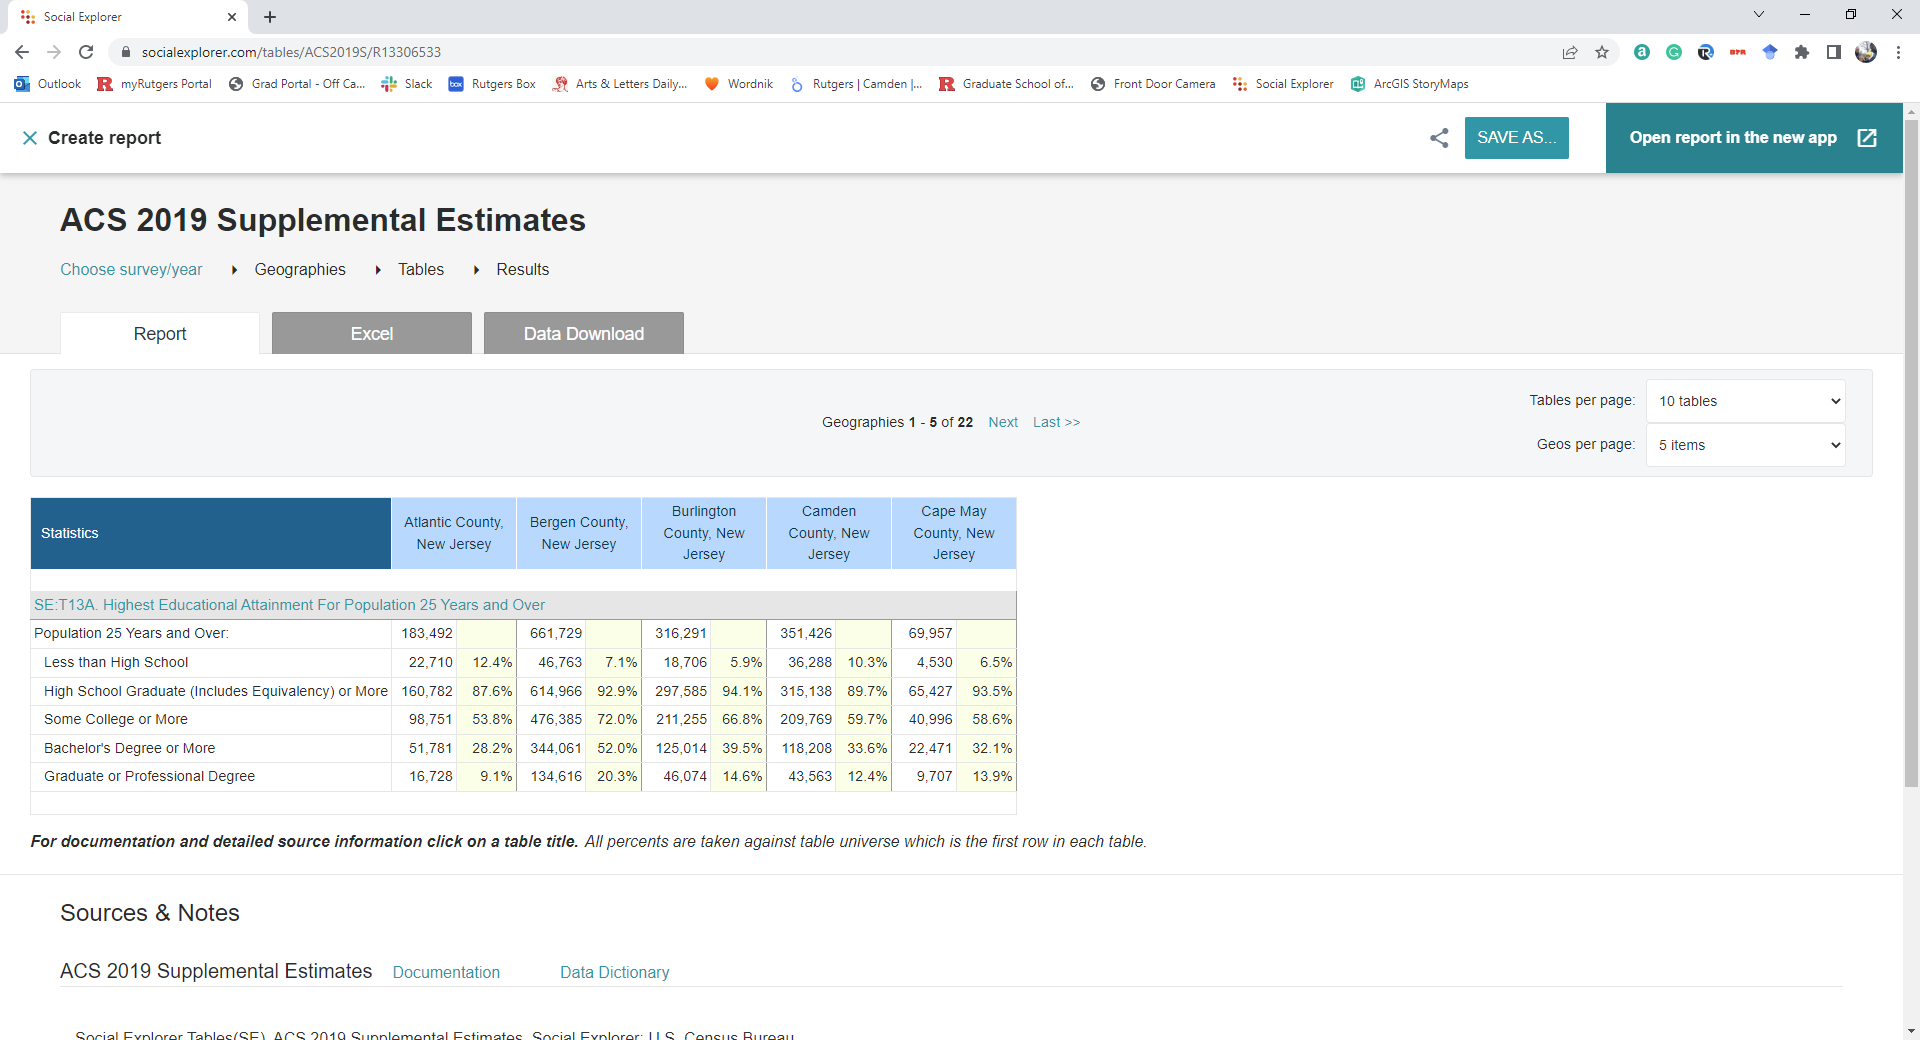

In [102]:
njhigh.dtypes

,0
Geo_FIPS,int64
Geo_NAME,object
Geo_QNAME,object
SE_T013A001,int64
SE_T013A002,int64
SE_T013A003,int64
SE_T013A004,int64
SE_T013A005,int64
SE_T013A006,int64


In [103]:
#Initially, I was goingto exclude less than High School of High School, but those variables may be negatively correlated and have a strong relationship.
njhigh = njhigh.rename(columns={'Geo_FIPS':"FIPS",
                                  "SE_T013A001":"PopOver25",
                                  "SE_T013A002":"LessthanHigh",
                                  "SE_T013A003":"High",
                                  "SE_T013A004":"SomeCollege",
                                  "SE_T013A005":"Bachelors",
                                  "SE_T013A006":"Grad"})

In [104]:
njhigh.dtypes

,0
FIPS,int64
Geo_NAME,object
Geo_QNAME,object
PopOver25,int64
LessthanHigh,int64
High,int64
SomeCollege,int64
Bachelors,int64
Grad,int64


In [105]:
njhigh = njhigh.rename(columns={'Geo_NAME':"County"})

### Import 5 - New Jersey Median Household Income
Retrieved this data from Social Explorer https://www.socialexplorer.com/tables/EASI2021/R13306534

In [106]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ewattudo/vis1/main/R13306534_SL050.csv", "njhhinc.csv")

('njhhinc.csv', <http.client.HTTPMessage at 0x7ef11b8976d0>)

In [107]:
os.getcwd() #pwd
os.listdir() #compare to clicking on the left the folder icon #dir

'/content'

['.config',
 'appdata',
 'njhighested.csv',
 'njunemp21.csv',
 'njhhinc.csv',
 'sample_data']

### Cleaning the Data 5 - New Jersey Median Houshold Income

In [108]:
njhhinc=pd.read_csv('njhhinc.csv')

In [109]:
njhhinc.columns

Index(['Geo_FIPS', 'Geo_NAME', 'Geo_QNAME', 'Geo_NATION', 'Geo_STATE',
       'Geo_COUNTY', 'Geo_CT', 'Geo_BG', 'Geo_CITY', 'Geo_MSAMSA', 'Geo_ZC',
       'ORG_MEDHHINC'],
      dtype='object')

In [110]:
njhhinc = njhhinc.rename(columns={'Geo_NAME':"County"})

In [111]:
njhhinc = njhhinc.drop(['Geo_NATION','Geo_QNAME','Geo_NATION','Geo_COUNTY','Geo_MSAMSA'],axis=1)

## Merging

In [112]:
njappdat.dtypes

,0
ID,int64
Degree Type,object
Final Recommended Decision,object
AdmitComing,int64
Application Created Date,object
Days,int64
Domestic or INTL Applicant,object
Reporting Term,object
Age,float64
Zip,object


In [ ]:
#Simplified data for merging. This lists all the NJ apps with cleaned Zips.
njappdat=njappdat[['ID ','C_Zip','AdmitComing','Days','Age','Program']]
njappdat.head(3)

,ID,C_Zip,AdmitComing,Days,Age,Program
2,3,07009,0,175,22.0,Biology: Computational and Integrative (MS)
3,4,07726,0,159,23.0,Biology: Computational and Integrative (MS)
5,6,08755,0,272,33.0,Biology: Computational and Integrative (MS)


In [ ]:
njzips.dtypes

City      object
C_Zip     object
County    object
dtype: object

In [ ]:
#This is the simplified data I am going to use to merge. These are the Zips I am going to use to find the county names.
njzips=njzips[['C_Zip','County']]

### Cleaning Zips for Merging

In [ ]:
print(njzips.C_Zip.unique())

['08401' '07747' '08201' '07102' '07710' '08009' '07820' '07840' '07401'
 '08501' '08720' '08001' '07012' '08096' '08865' '07620' '07017' '08037'
 '07821' '08260' '08801' '07032' '08802' '07753' '07712' '08043' '08004'
 '08402' '08403' '08406' '08233' '07716' '08085' '08106' '07822' '08028'
 '08202' '07717' '07421' '08803' '08005' '08006' '08080' '08007' '07422'
 '07920' '07939' '08742' '07002' '08721' '07202' '08008' '08050' '08722'
 '07416' '07921' '07461' '08223' '07718' '08677' '08502' '08270' '07109'
 '07823' '07304' '07621' '07087' '08757' '07922' '07924' '07201' '08010'
 '08066' '08011' '08349' '08012' '07825' '08504' '07003' '07403' '08804'
 '07603' '07005' '08505' '08805' '08108' '07746' '07720' '08876' '07826'
 '07827' '07890' '07018' '08075' '08014' '08302' '08807' '08730' '08203'
 '08808' '08030' '07926' '08015' '07828' '08310' '08210' '08016' '07405'
 '07829' '07830' '08107' '08109' '08110' '08204' '08212' '08232' '07072'
 '08332' '08069' '07008' '07030' '08094' '07758' '0

In [ ]:
njappzip=njappdat.merge(njzips, on='C_Zip',how='outer',indicator=True)
njappzip.dtypes

ID              float64
C_Zip            object
AdmitComing     float64
Days            float64
Age             float64
Program          object
County           object
_merge         category
dtype: object

In [ ]:
njappzip._merge.value_counts()

both          874
right_only    816
left_only      62
Name: _merge, dtype: int64

In [ ]:
#Not sure why these aren't merging.
njappzip['C_Zip'][njappzip['_merge']=='left_only'].unique()

array(['08755', '08034', '07522', '07450', '08102', '08031', '08103',
       '08817', '08618', '08234', '07311', '08611', '08361', '08205',
       '08861', '08610', '07960', '07063', '08844', '08854', '07090',
       '07042', '07013', '08629', '07302', '07050'], dtype=object)

In [ ]:
#Not sure why these aren't merging.
njappzip['C_Zip'][njappzip['_merge']=='right_only'].unique()

array(['08201', '07102', '07710', '07820', '07401', '08501', '08720',
       '08001', '07012', '07620', '07017', '07821', '08260', '08801',
       '07032', '08802', '07712', '08402', '08403', '08406', '08233',
       '07716', '07822', '08202', '07717', '07421', '08803', '08006',
       '07422', '07920', '07939', '08742', '07002', '08721', '07202',
       '08008', '08050', '08722', '07416', '07921', '07461', '08223',
       '07718', '08677', '08270', '07823', '07621', '07087', '08757',
       '07922', '07924', '07201', '08011', '08349', '07825', '08504',
       '07003', '07403', '08804', '07603', '07005', '08805', '07746',
       '07720', '07826', '07827', '07890', '07018', '08014', '08807',
       '08730', '08203', '08808', '08030', '07926', '07828', '08310',
       '08210', '07829', '08212', '07072', '08332', '07758', '08018',
       '07927', '08092', '08311', '08318', '07831', '07928', '07193',
       '08089', '07930', '07066', '08020', '08510', '08312', '07010',
       '07721', '074

In [ ]:
#Ahh, I get it. SOme of these zips, might not have any applicants. 08201 is a small county outside Atlantic City. It's perfectly reasonable to not have gradute school applications from these cities and counties.
njappzipwrong = njappzip.query("_merge=='right_only'")
njappzipwrong.head(5)

,ID,C_Zip,AdmitComing,Days,Age,Program,County,_merge
936,NaN,08201,NaN,NaN,NaN,NaN,ATLANTIC,right_only
937,NaN,08201,NaN,NaN,NaN,NaN,ATLANTIC,right_only
938,NaN,08201,NaN,NaN,NaN,NaN,ATLANTIC,right_only
939,NaN,08201,NaN,NaN,NaN,NaN,ATLANTIC,right_only
940,NaN,08201,NaN,NaN,NaN,NaN,ATLANTIC,right_only


In [ ]:
njappzipmerge = njappzip.query("_merge=='both'")
njappzipmerge.head(3)
njappzipmerge.tail(3)

,ID,C_Zip,AdmitComing,Days,Age,Program,County,_merge
0,3.0,07009,0.0,175.0,22.0,Biology: Computational and Integrative (MS),ESSEX,both
1,3.0,07009,0.0,175.0,22.0,Biology: Computational and Integrative (MS),ESSEX,both
2,4.0,07726,0.0,159.0,23.0,Biology: Computational and Integrative (MS),MONMOUTH,both


,ID,C_Zip,AdmitComing,Days,Age,Program,County,_merge
933,1495.0,08106,1.0,105.0,31.0,Teacher Education (MAT),CAMDEN,both
934,1520.0,07040,0.0,78.0,35.0,Teacher Education - Spanish (MAT),ESSEX,both
935,1520.0,07040,0.0,78.0,35.0,Teacher Education - Spanish (MAT),ESSEX,both


### Cleaning the Counties for Merging

In [ ]:
njunemp=njunemp[['County','Unemployment2021','PercentageChange']]
njunemp.head(3)

,County,Unemployment2021,PercentageChange
0,Atlantic,10.8,-55.000000
1,Bergen,7.4,-47.517730
2,Burlington,6.6,-44.067797


In [ ]:
print(njunemp.County.unique())

['Atlantic ' 'Bergen ' 'Burlington ' 'Camden ' 'Cape May ' 'Cumberland '
 'Essex ' 'Gloucester ' 'Hudson ' 'Hunterdon ' 'Mercer ' 'Middlesex '
 'Monmouth ' 'Morris ' 'Ocean ' 'Passaic ' 'Salem ' 'Somerset ' 'Sussex '
 'Union ' 'Warren ']


In [ ]:
njunemp['County'] = njunemp['County'].str.replace(' ', '')

<ipython-input-192-c6d41c4171de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  njunemp['County'] = njunemp['County'].str.replace(' ', '')


In [ ]:
print(njunemp.County.unique())

['Atlantic' 'Bergen' 'Burlington' 'Camden' 'CapeMay' 'Cumberland' 'Essex'
 'Gloucester' 'Hudson' 'Hunterdon' 'Mercer' 'Middlesex' 'Monmouth'
 'Morris' 'Ocean' 'Passaic' 'Salem' 'Somerset' 'Sussex' 'Union' 'Warren']


In [ ]:
print(njappzip.County.unique())

['ESSEX' 'MONMOUTH' nan 'MIDDLESEX' 'SUSSEX' 'CAMDEN' 'BURLINGTON'
 'HUDSON' 'UNION' 'GLOUCESTER' 'OCEAN' 'SOMERSET' 'ATLANTIC' 'CUMBERLAND'
 'MERCER' 'CAPE MAY' 'BERGEN' 'WARREN' 'MORRIS' 'HUNTERDON' 'SALEM'
 'PASSAIC']


In [ ]:
njappzip["County"]= njappzip["County"].str.title()

In [ ]:
print(njhigh.County.unique())

['Atlantic County' 'Bergen County' 'Burlington County' 'Camden County'
 'Cape May County' 'Cumberland County' 'Essex County' 'Gloucester County'
 'Hudson County' 'Hunterdon County' 'Mercer County' 'Middlesex County'
 'Monmouth County' 'Morris County' 'Ocean County' 'Passaic County'
 'Salem County' 'Somerset County' 'Sussex County' 'Union County'
 'Warren County']


In [ ]:
njhigh['County'] = njhigh['County'].str.replace('County', '')

In [ ]:
print(njhigh.County.unique())

['Atlantic ' 'Bergen ' 'Burlington ' 'Camden ' 'Cape May ' 'Cumberland '
 'Essex ' 'Gloucester ' 'Hudson ' 'Hunterdon ' 'Mercer ' 'Middlesex '
 'Monmouth ' 'Morris ' 'Ocean ' 'Passaic ' 'Salem ' 'Somerset ' 'Sussex '
 'Union ' 'Warren ']


In [ ]:
njhigh['County'] = njhigh['County'].str.replace('  ', '')

In [ ]:
print(njhigh.County.unique())

['Atlantic ' 'Bergen ' 'Burlington ' 'Camden ' 'Cape May ' 'Cumberland '
 'Essex ' 'Gloucester ' 'Hudson ' 'Hunterdon ' 'Mercer ' 'Middlesex '
 'Monmouth ' 'Morris ' 'Ocean ' 'Passaic ' 'Salem ' 'Somerset ' 'Sussex '
 'Union ' 'Warren ']


In [ ]:
print(njhhinc.County.unique())

['Atlantic' 'Bergen' 'Burlington' 'Camden' 'Cape May' 'Cumberland' 'Essex'
 'Gloucester' 'Hudson' 'Hunterdon' 'Mercer' 'Middlesex' 'Monmouth'
 'Morris' 'Ocean' 'Passaic' 'Salem' 'Somerset' 'Sussex' 'Union' 'Warren']


In [ ]:
del njappzip['_merge']
njappzipunemp=njappzip.merge(njunemp, on='County',how='outer',indicator=True)
njappzipunemp.dtypes

ID                   float64
C_Zip                 object
AdmitComing          float64
Days                 float64
Age                  float64
Program               object
County                object
Unemployment2021     float64
PercentageChange     float64
_merge              category
dtype: object

In [ ]:
njappzipunemp._merge.value_counts()

both          1615
left_only      137
right_only       1
Name: _merge, dtype: int64

In [ ]:
#nan makes sense, not sure why Cape May isn't merging.
njappzipunemp['County'][njappzipunemp['_merge']=='left_only'].unique()

array([nan, 'Cape May'], dtype=object)

In [ ]:
del njappzipunemp['_merge']
njappzipunemphigh=njappzipunemp.merge(njhigh, on='County',how='outer',indicator=True)
njappzipunemphigh.dtypes

ID                   float64
C_Zip                 object
AdmitComing          float64
Days                 float64
Age                  float64
Program               object
County                object
Unemployment2021     float64
PercentageChange     float64
FIPS                 float64
Geo_QNAME             object
PopOver25            float64
LessthanHigh         float64
High                 float64
SomeCollege          float64
Bachelors            float64
Grad                 float64
_merge              category
dtype: object

In [ ]:
njappzipunemphigh._merge.value_counts()

left_only     1753
right_only      21
both             0
Name: _merge, dtype: int64

In [ ]:
#I see the problem now, CapeMay and Cape May #todo fix Cape May
njappzipunemphigh['County'][njappzipunemphigh['_merge']=='left_only'].unique()

array(['Essex', 'Monmouth', nan, 'Middlesex', 'Sussex', 'Camden',
       'Burlington', 'Hudson', 'Union', 'Gloucester', 'Ocean', 'Somerset',
       'Atlantic', 'Cumberland', 'Mercer', 'Cape May', 'Bergen', 'Warren',
       'Morris', 'Hunterdon', 'Salem', 'Passaic', 'CapeMay'], dtype=object)

In [ ]:
#todo clean list of columns
del njappzipunemphigh['_merge']
finalmerge=njappzipunemphigh.merge(njhhinc, on='County',how='outer',indicator=True)
finalmerge.dtypes

ID                   float64
C_Zip                 object
AdmitComing          float64
Days                 float64
Age                  float64
Program               object
County                object
Unemployment2021     float64
PercentageChange     float64
FIPS                 float64
Geo_QNAME             object
PopOver25            float64
LessthanHigh         float64
High                 float64
SomeCollege          float64
Bachelors            float64
Grad                 float64
Geo_FIPS             float64
Geo_STATE            float64
Geo_CT               float64
Geo_BG               float64
Geo_CITY             float64
Geo_ZC               float64
ORG_MEDHHINC         float64
_merge              category
dtype: object

## Five Files Merged

I am eager to manipulate this data to see if there are any findings, but for now I am going to focus my visualizations on the initial data.

In [ ]:
finalmerge._merge.value_counts()

both          1690
left_only       63
right_only       0
Name: _merge, dtype: int64

In [ ]:
finalmerge.dtypes

ID                   float64
C_Zip                 object
AdmitComing          float64
Days                 float64
Age                  float64
County                object
Unemployment2021     float64
PercentageChange     float64
FIPS                 float64
Geo_QNAME             object
PopOver25            float64
LessthanHigh         float64
High                 float64
SomeCollege          float64
Bachelors            float64
Grad                 float64
Geo_FIPS             float64
Geo_STATE            float64
Geo_CT               float64
Geo_BG               float64
Geo_CITY             float64
Geo_ZC               float64
ORG_MEDHHINC         float64
_merge              category
dtype: object

In [ ]:
finalmerge.head(2)

,ID,C_Zip,AdmitComing,Days,Age,County,Unemployment2021,PercentageChange,FIPS,Geo_QNAME,...,Bachelors,Grad,Geo_FIPS,Geo_STATE,Geo_CT,Geo_BG,Geo_CITY,Geo_ZC,ORG_MEDHHINC,_merge
0,3.0,07009,0.0,175.0,22.0,Essex,9.5,-42.771084,NaN,NaN,...,NaN,NaN,34013.0,34.0,NaN,NaN,NaN,NaN,77043.0,both
1,3.0,07009,0.0,175.0,22.0,Essex,9.5,-42.771084,NaN,NaN,...,NaN,NaN,34013.0,34.0,NaN,NaN,NaN,NaN,77043.0,both


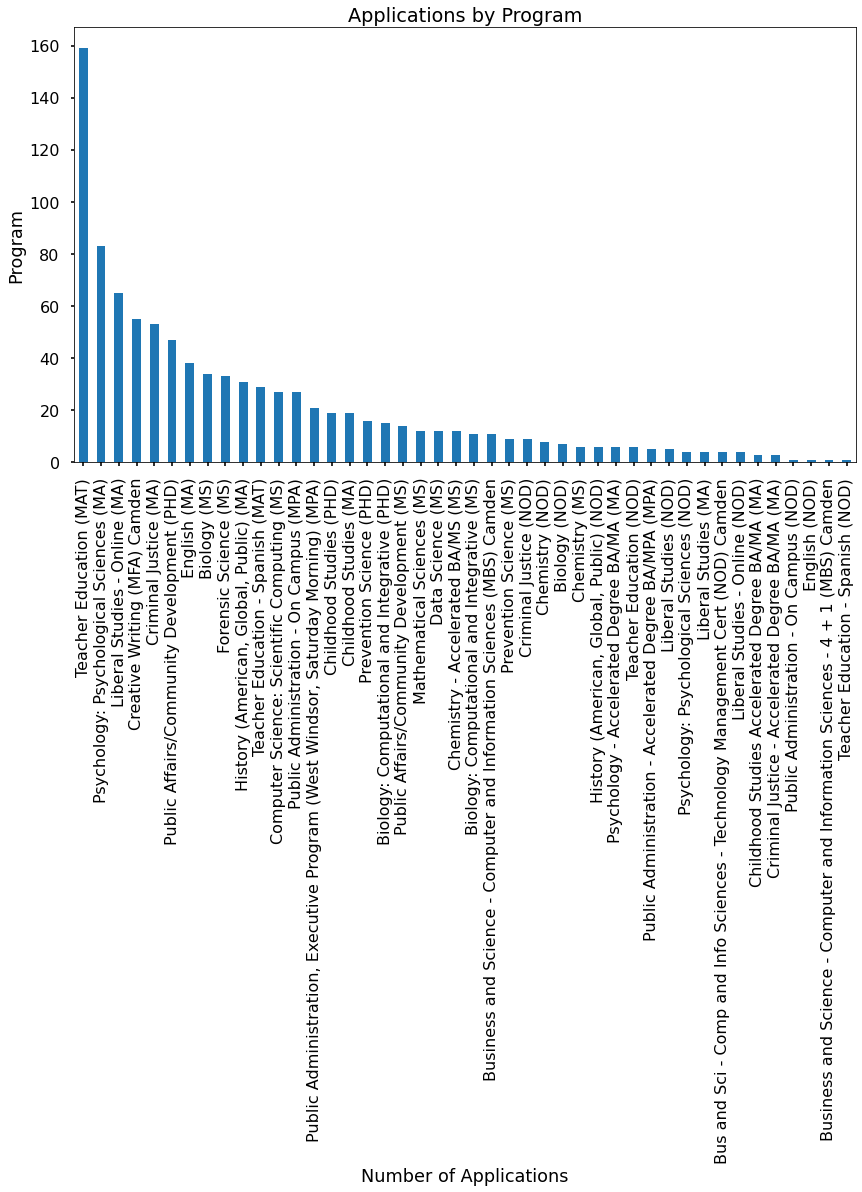

In [ ]:
#aok here just trying your graph on merged data; quite different wonder why...
ax = finalmerge['Program'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Applications by Program")
ax.set_xlabel("Number of Applications")
ax.set_ylabel("Program");

## Telling the Story: Who Applies

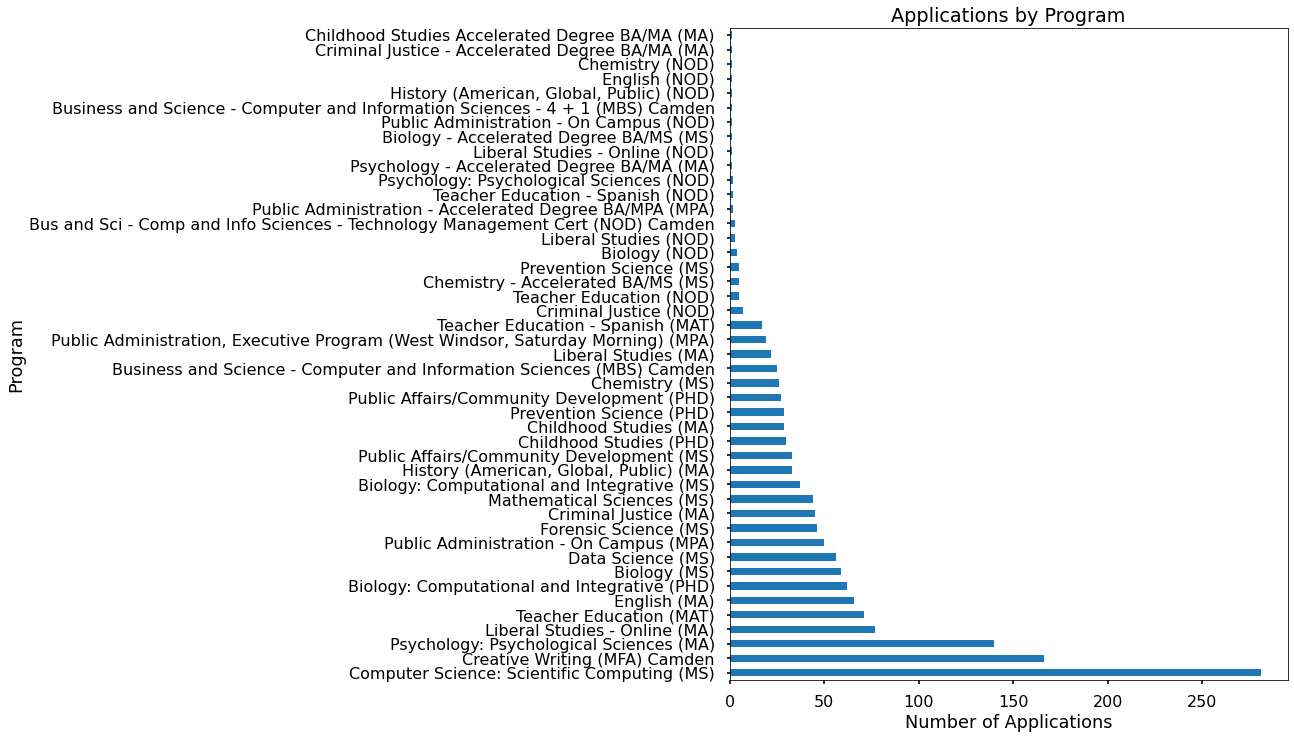

In [ ]:
#I used the data from this graph in a meeting I had this week. So I want to keep it although it isn't related to the story.
#aok yep thats totally fine; in general, can have more than 1 notebooks for different projects/angles in addition to different sections/subsections in one notebook
#maybe horizontal bar cleaner?; but totally personal preference!
#could also drop those say fewer than 10
#could also stack or overlay or next to each other say by intl/domestic, gender, race, etc
ax = appdat['Program'].value_counts().plot(kind='barh',
                                    figsize=(10,12),
                                    title="Applications by Program")
ax.set_xlabel("Number of Applications")
ax.set_ylabel("Program");


### Days Between When Applicant Starts and the Start of the Semester

In [ ]:
appdat['Days'].describe().astype(int)

count    1538
mean      187
std        89
min        15
25%       113
50%       169
75%       254
max       494
Name: Days, dtype: int64

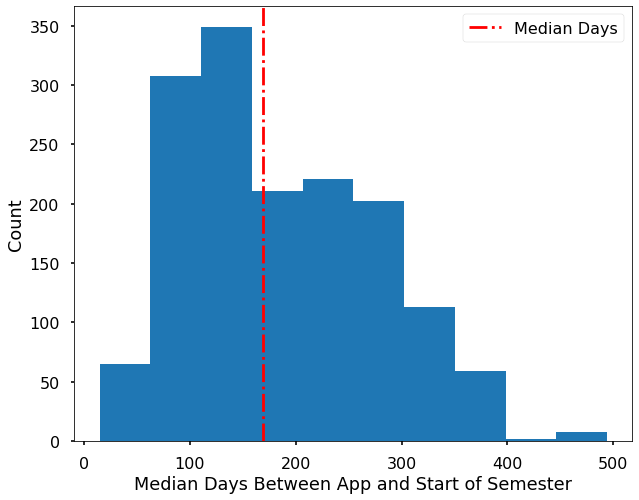

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.hist(appdat.Days)
meddays=appdat.Days.median()
ax.axvline(meddays, color="red", ls="dashdot", label="Median Days")
ax.set_xlabel('Median Days Between App and Start of Semester')
ax.set_ylabel('Count')
ax.legend();
#aok yes great to show stuff like median, but also consider other meaninggful quantities
# say natl avg, NB avg etc etc

This right skewed histogram is surprising. It is very interesting that so many people apply to graduate school less than 200 days before the beginning of the semester, especially because later that data suggests that international students in particular apply so late.

aok yes interesting/unexpected then can also break down by country, maybe mostly due to one or few countries; ideally if also had a variable whether camden was student's first choice; or maybe administrative variable, whether say transfer from NB

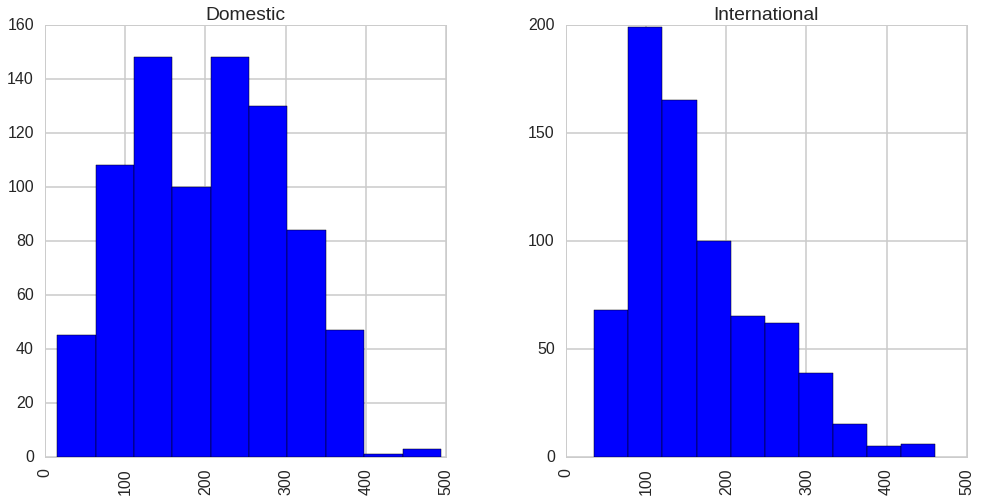

In [ ]:
appdat.Days.hist(by=appdat.Domestic, figsize=(16, 8));plt.show();

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


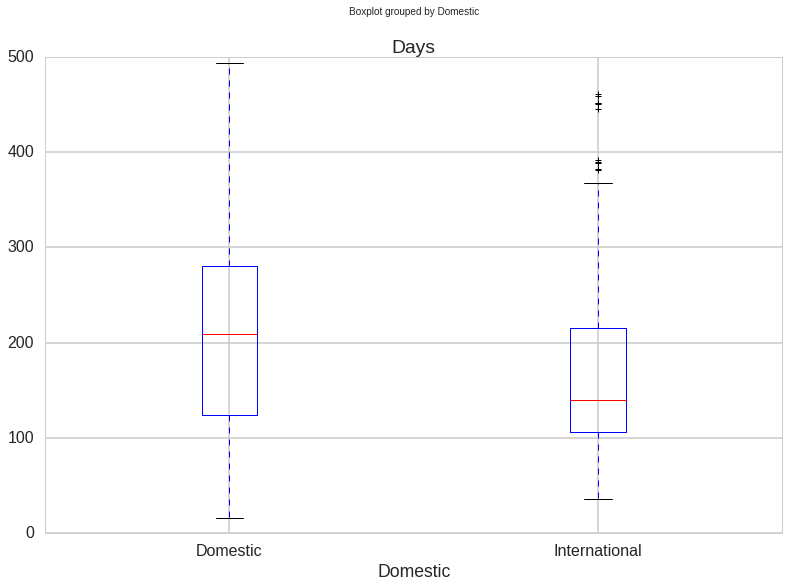

In [ ]:
appdat.boxplot(column="Days", by="Domestic"),plt.show();
#aok cool yes then can also ID these outliers, can simply subset intl where days>350 or 400

This is by far the most surprising. I was convinced that international students would apply earlier since the burden is so high. There are quite a few outliers on the international plot, but this is fascinating.

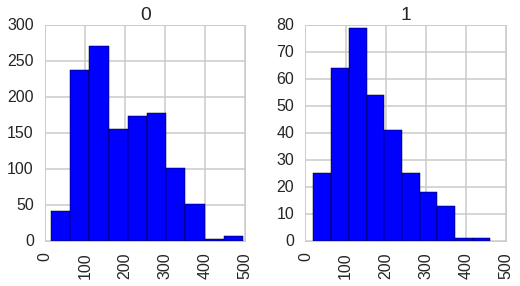

In [ ]:
appdat.Days.hist(by=appdat.AdmitComing, figsize=(8, 4));plt.show();

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


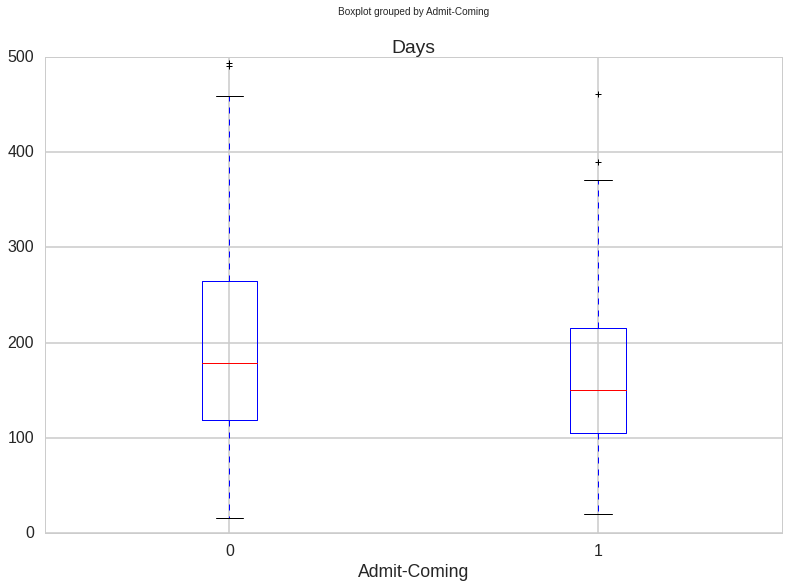

In [ ]:
appdat.boxplot(column="Days", by="Admit-Coming"),plt.show();

This is also very surprising. Those students who accept our offers of admission are more likely to have applied later. I am beginning to believe that this is a clear indication that we may be a fallback school. More analysis is needed, but this is my new hypothesis.

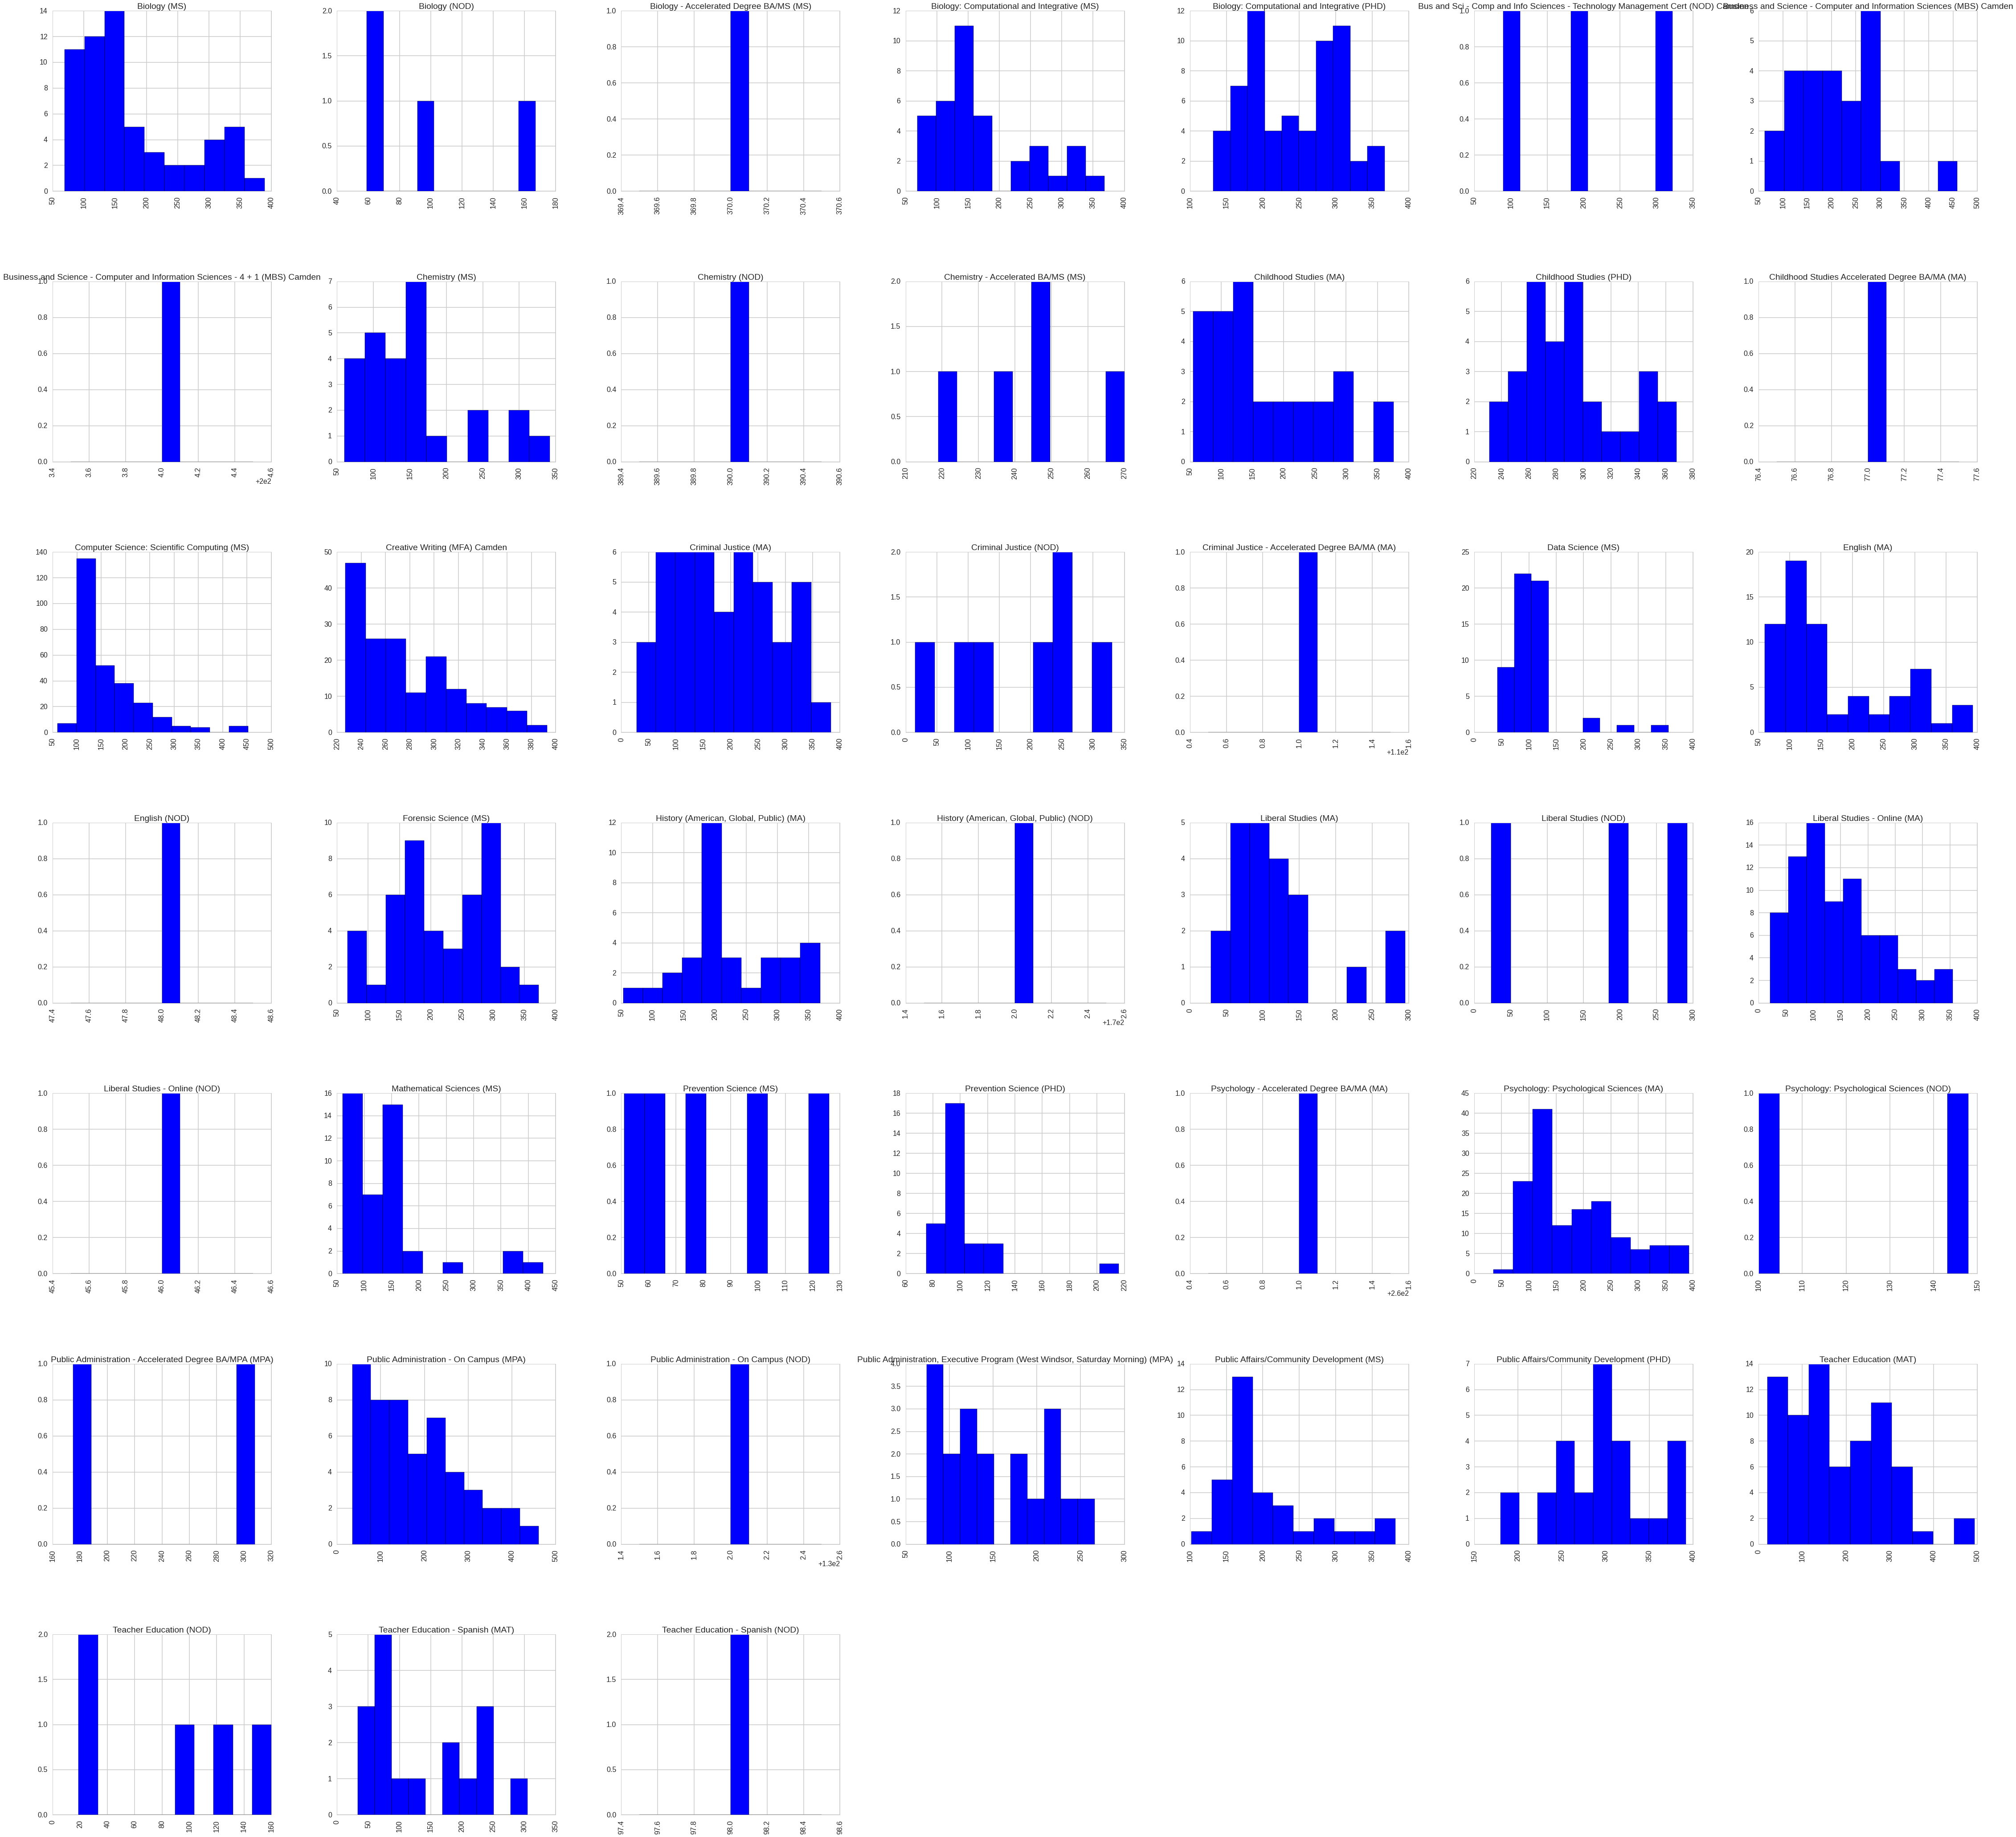

In [ ]:
appdat.Days.hist(by=appdat.Program, figsize=(75, 75));plt.show();

I find this interesting but not actionable.

aok clean it up eg run only for bigger programs